# Use STpipe to identify false positive genes

Compiled: April 5, 2024

For this tutorial, we will be analyzing the a dataset of zebrafish 10hpf embryos freely available from stomics. There are 19102 single cells that were sequenced on the 
DNBSEQ-T1. The Stereo-seq data is from https://db.cngb.org/stomics/datasets/STDS0000057. Click on the "Data" tab, where you can find Stereo-seq and scrna-seq data for zebrafish 10hpf embryos. Both datasets have been analyzed, but we can demonstrate using the raw counts for further analysis.

## Import the required packages

In [62]:
import anndata
import stpipe as sp
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
from collections import OrderedDict

## Import the zebrafish Stereo-seq and scRNA-seq data

In [45]:
adata=anndata.read_h5ad('zf10_stereoseq.h5ad')

In [46]:
adata

AnnData object with n_obs × n_vars = 19102 × 18698
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors'
    layers: 'counts'

In [47]:
adata.X=adata.layers['counts']

In [48]:
adata.obs['slice'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

bdata is already lognormal

In [49]:
bdata=anndata.read_h5ad('f10_scRNA.h5ad')

## Normalize

STpipe utilizes the global-scaling normalization method called "LogNormalize". This method normalizes the measured expression values of each feature in each cell by the total expression across all features, multiplying by a scaling factor (default is 10000), and then applying a logarithmic transformation to the result.

For scaling factor, you can refer to the maximum number of counts and try to avoid a gap of several orders of magnitude. This will affect subsequent differential expression gene analysis.

In [50]:
np.max(np.sum(adata.X, axis=1))

1983.0

In [51]:
adata=sp.lognormal(adata,scale_factor=2000)

## Identify false positive genes

Next, we proceed to identify false positive genes. Due to misalignment of adata slices in 3D, we choose slice 10 as an example.

In [52]:
adata = adata[adata.obs['slice']==10]

In [54]:
adata = sp.filter_genes(adata,min_cells=1)

In [55]:
adata.obsm['spatial']=adata.obs[['spatial_x','spatial_y']].values

In [36]:
markers = pd.read_csv('zf10_cellmarkers.txt')

In [56]:
m_sp,m_sc,ad_ge,sp=sp.falsepositive(adata,bdata,train_gene=markers.gene)

[scatterd] >INFO> 309 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
[scatterd] >INFO> 11963 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
[scatterd] >INFO> uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
[scatterd] >INFO> rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
[scatterd] >INFO> Allocate tensors for mapping.
[scatterd] >INFO> Begin training with 309 genes and rna_count_based density_prior in cells mode...
[scatterd] >INFO> Saving results..


In [67]:
m_sc_filtered = m_sc[m_sc < 0.05].index.tolist()
m_sp_filtered = m_sp[m_sp > 0.2].index.tolist()
intersecting_genes = set(m_sc_filtered).intersection(set(m_sp_filtered))
print(len(intersecting_genes))

9


We select genes with high Moran I values in spatial transcriptomics but low in scRNA-seq data. Users should inspect these genes to consider their removal to avoid bias in subsequent cell type annotations.

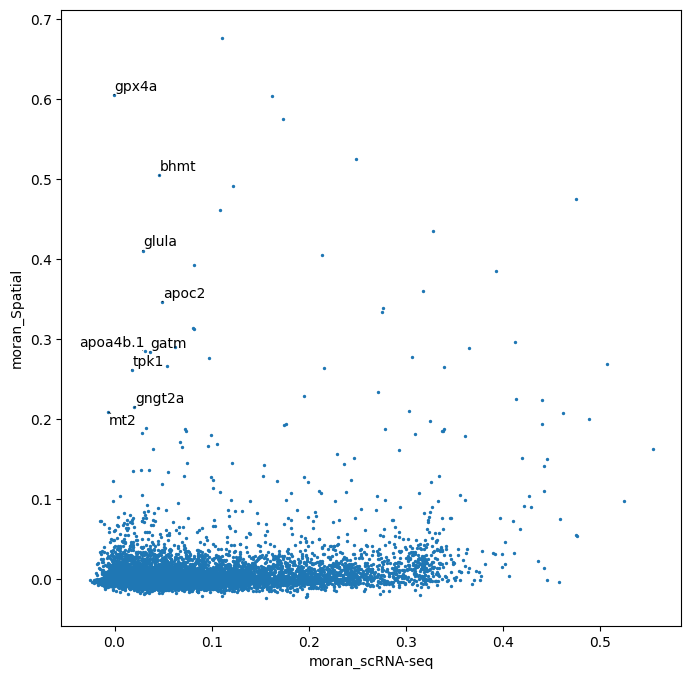

In [68]:
sp.plot_moran(m_sc,m_sp,anno=intersecting_genes,figsize=(8,8))